# Task 1: Aquire the data

In [3]:
from tensorflow import keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.special import softmax

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
x_train.shape # 60000 28x28 train images

(60000, 28, 28)

In [6]:
# inputs for CNN convolutional layers (not flattened)
x_train_img = x_train.reshape(60000,28,28,1)/255
x_test_img = x_test.reshape(10000,28,28,1)/255


In [7]:
np.unique(y_train) # 10 labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
x_test.shape # 10000 28x28 test images

(10000, 28, 28)

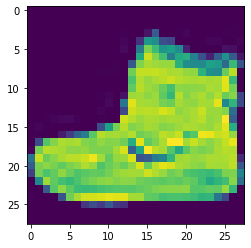

In [9]:
# check how the image looks like without preprocessing 
plt.figure()
plt.imshow(x_train[0]) # show the first image of the dataset from train_images
# plt.colorbar() # see the intensity of the pixel of the image
plt.show() 

In [10]:
# we need to flatten the images so we can put it into the MLP 
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

In [11]:
# nomalization 
xmean_train = np.mean(x_train,axis=1).reshape(60000,1)
xmean_test = np.mean(x_test, axis=1).reshape(10000,1)
xstd_train = np.std(x_train,axis=1).reshape(60000,1)
xstd_test = np.std(x_test,axis=1).reshape(10000,1)

# unormalized training data
x_train_unnorm = x_train
x_test_unnorm = x_test
x_train = (x_train - xmean_train)/xstd_train # subtract the mean to center the cloud of data around the origin along every dimension (the data is centered at 0)
x_test = (x_test - xmean_test)/xstd_test

In [12]:
# change labels from N x 1 to N x C
y_train_C = keras.utils.to_categorical(y_train,10)
y_test_C = keras.utils.to_categorical(y_test,10)

## Exploration


In [189]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
labels = []
for i in range(len(y_train)):
  labels.append(class_names[y_train[i]])

In [190]:
labels[0]

'Ankle boot'

In [191]:
count = pd.Series(labels[:]).value_counts()
print(count) 

Ankle boot     6000
T-shirt/top    6000
Dress          6000
Pullover       6000
Sneaker        6000
Sandal         6000
Trouser        6000
Shirt          6000
Coat           6000
Bag            6000
dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Ankle boot'),
  Text(1, 0, 'T-shirt/top'),
  Text(2, 0, 'Dress'),
  Text(3, 0, 'Pullover'),
  Text(4, 0, 'Sneaker'),
  Text(5, 0, 'Sandal'),
  Text(6, 0, 'Trouser'),
  Text(7, 0, 'Shirt'),
  Text(8, 0, 'Coat'),
  Text(9, 0, 'Bag')])

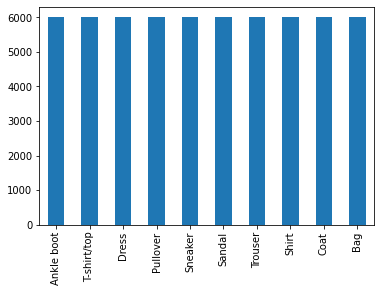

In [192]:
count.plot.bar(rot=0) # so we have 6000 sample per label
plt.xticks(rotation ='vertical')

# Task 2: Implement a Multilayer Perceptron

In [19]:
def softmax_n(x):
  result = []
  for i in range(x.shape[0]):
    result.append(softmax(x[i]))
  return np.stack(result,axis=0)

# use softmax at last layer
class MLP:
    
    def __init__(self, M=64, layer_num=2, active_func="relu", lrelu_gamma=0.7,dropout=1): # M is number of hidden units
        self.M = M
        self.layer_num = layer_num
        self.lrelu_gamma = lrelu_gamma
        self.dropout = dropout
        
        def lrelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = x[i][j]
              else:
                temp[i][j] = x[i][j] * self.lrelu_gamma
          return temp

        def relu(d):
          temp = np.copy(d)
          for i in range(d.shape[0]):
            for j in range(d.shape[1]):
              if d[i][j] > 0:
                temp[i][j] = d[i][j]
              else:
                temp[i][j] = 0
          return temp

        np_tanh = lambda x: np.tanh(x)

        def dlrelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = 1
              elif x[i][j] < 0:
                temp[i][j] = self.lrelu_gamma
              else:
                temp[i][j] = 0
          return temp
            
        def drelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = 1
              else:
                temp[i][j] = 0
          return temp

        def dtanh(x):
          return 1 - (np.tanh(x) * np.tanh(x))

        if active_func == "lrelu":
          self.acfun = lrelu
          self.dfunc = drelu
        elif active_func == "relu":
          self.acfun = relu
          self.dfunc = drelu
        elif active_func == "tanh": 
          self.acfun = np_tanh
          self.dfunc = np.vectorize(dtanh)
                    
    def fit(self, x, y, optimizer,pre_params=[]):
        N,D = x.shape
        def gradient(x, y, params):
          dparams = []
          # has 0 hidden layer [w0]
          if len(params) == 1:
            #forward
            w0 = params[0] # D x C
            yh = softmax_n(np.dot(x,w0)) # N x D dot D x C -> N x C
            # yh = np.argmax(yh_before,axis=1)[:,None] # change from N x C -> N x 1
            dy = yh - y # N x C
            
            #backprop
            dw0 = np.dot(x.T, dy) # D x N dot N x C -> D x C
            dparams = [dw0] # D x C


          elif len(params) == 2: # hidden = 1
            # forward
            w0,w1 = params # w0: D x M, w1: M x C
            s0 = np.dot(x,w0) # N x M
            z0 = self.acfun(s0) # N x M
            s1 = np.dot(z0,w1) # N x M dot M x C -> N x C
            yh= softmax_n(s1) # N x C
            dy = (yh - y) # N x C

            # backprop
            dw1 = np.dot(z0.T,dy) # M x N dot N x C -> M x C
            tmp = np.dot(dy,w1.T) # N x C dot C x M -> N x M
            tmp = tmp * self.dfunc(s0) # N x M * N x M -> N x M       
            dw0 = np.dot(x.T, tmp) # D x N dot N x M -> D x M
            dparams = [dw0,dw1] # dw0: D x M, dw1: M x C
            
          elif len(params) == 3: # hidden = 2
            # forward
            w0,w1,w2 = params # w0: D x M, w1: M x M, w2: M x C
            s0 = np.dot(x,w0) # N x D dot D x M -> N x M
            z0 = self.acfun(s0) # N x M
            s1 = np.dot(z0,w1) # N x M dot M x M -> N x M
            z1 = self.acfun(s1) # N x M
            s2 = np.dot(z1,w2) # N x M dot M x C -> N x C
            yh = softmax_n(s2) # N x C -> N x C
            dy = (yh - y) # N x C

            # backprop
            dw2 = np.dot(z1.T, dy) # M x N dot N x C -> M x C

            term1 = np.dot(w2,dy.T) # M x C dot C x N -> M x N
            term2 = self.dfunc(s1) * z0 # N x M * N x M -> N x M
            dw1 = np.dot(term1,term2) # M x N dot N x M -> M x M

            term1 = np.dot(dy,w2.T) # N x C dot C x M -> N x M
            term2 = term1 * self.dfunc(s1) # N x M * N x M
            term3 = np.dot(term2, w1) # N x M dot M x M -> N x M
            term4 = term3 * self.dfunc(s0) # N x M * N x M -> N x M
            dw0 = np.dot(x.T,term4) # D x N dot N x M -> D x M
            dparams = [dw0,dw1,dw2]
          return dparams

        M_new = int(self.M * self.dropout) + 1 # size + 1 (the bias)
        D_new = int(D * self.dropout)
        x_new = np.copy(x)
        if self.dropout < 1:
          # select randomly some features if dropout < 1
          self.drop_index = np.random.randint(D,size=D_new)
          x_new = x_new[:,self.drop_index]

        D_new += 1 # size + 1 (the bias)
        # add 1 column of random numbers to x as bias (bias is in shape N x 1)
        new_col = np.random.randn(N,1) * .01
        x_new = np.append(x_new,new_col,axis=1)
          
        # if trained based on previous params
        if pre_params != []:
          params0 = pre_params
        else:
          C = 10
          if self.layer_num == 0:
            w0 = np.random.randn(D_new,C) * .01 # D x C
            params0 = [w0]
          elif self.layer_num == 1:
            w0 = np.random.randn(D_new,M_new) * .01 # D x M
            w1 = np.random.randn(M_new,C) * .01 # M x C
            params0 = [w0,w1]
          elif self.layer_num == 2:
            w0 = np.random.randn(D_new,M_new) * .01 # D x M
            w1 = np.random.randn(M_new,M_new) * .01 # M x M
            w2 = np.random.randn(M_new,C) * .01 # M x C
            params0 = [w0,w1,w2]

        self.params = optimizer.run(gradient, x_new, y, params0)
        return self
    
    def predict(self, x):
      if(self.dropout < 1):
        input = x[:,self.drop_index]
      else:
        input = x

      for i in range(len(self.params)):
        if(i  == len(self.params)-1):
          input = np.dot(input,self.params[i][:-1]) # igonore the bias row when predicting
        else:
          input = self.acfun(np.dot(input,self.params[i][:-1,:-1])) 
      yh = softmax(input)
      return yh

    def evaluate_acc(self,y_pred,y_true):
      # y_pred and y_true are N x C
      y_pred = np.argmax(y_pred,axis=1)
      y_true = np.argmax(y_true,axis=1)
      return np.sum(y_pred == y_true)/y_true.shape[0]

In [20]:
class GradientDescent:
  # default batch size 30
  def __init__(self, learning_rate=.001, max_iters=10000, epsilon=1e-8, batch_size = 30):
      self.learning_rate = learning_rate
      self.max_iters = max_iters
      self.epsilon = epsilon
      self.batch_size = batch_size
      
  def run(self, gradient_fn, x, y, params):
      # cur_loss = np.array([np.inf])
      norms = np.array([np.inf])
      t = 1
      while np.any(norms > self.epsilon) and t < self.max_iters:
        # sampling a batch size of 100 from all indexes in x
        N,D = x.shape
        C = 10
        batch_index = np.random.randint(N,size=self.batch_size)
        x_batch = x[batch_index] # N x D
        y_batch = y[batch_index] # N x C
        grad = gradient_fn(x_batch, y_batch, params)
        for p in range(len(params)):
          params[p] -= self.learning_rate * grad[p]
        t += 1
        norms = np.array([np.linalg.norm(g) for g in grad])
      # print(t)
      return params

# Task 3: Run the experiments and report

In [199]:
# optimizer used for all experiments
optimizer = GradientDescent(learning_rate=0.0002,max_iters=6000)

In [200]:
def compare_models(model_list,optimizer):
  test_acc = []
  for model in model_list:
    model.fit(x_train,y_train_C,optimizer)
    y_pred = model.predict(x_test)
    test_acc.append([model.evaluate_acc(y_pred,y_test_C)])
  return test_acc

In [201]:
# creating models
column_names = ['Test Accuracy','Activate Function','Hidden Layer','Dropout Ratio','Normalized Train Data']
MLP_0L = MLP(layer_num=0)
MLP_1L = MLP(layer_num=1,M=128,active_func="relu")
MLP_2L = MLP(layer_num=2,M=128,active_func="relu")
model_list = [MLP_0L,MLP_1L,MLP_2L] # compare depths
acc_list = compare_models(model_list,optimizer)
acc_list[0].extend(["Relu",0,1,True])
acc_list[1].extend(["Relu",1,1,True])
acc_list[2].extend(["Relu",2,1,True])
df = pd.DataFrame(acc_list,columns=column_names)
df

,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.8352,Relu,0,1,True
1,0.8334,Relu,1,1,True
2,0.7405,Relu,2,1,True


In [202]:
MLP_2L_lrelu = MLP(layer_num=2,M=128,active_func="lrelu")
MLP_2L_tanh = MLP(layer_num=2,M=128,active_func="tanh")
models_acfun = [MLP_2L,MLP_2L_lrelu,MLP_2L_tanh] # compare acfuns
acc_list = compare_models(models_acfun,optimizer)
acc_list[0].extend(["Relu",2,1,True])
acc_list[1].extend(["Leaky Relu",2,1,True])
acc_list[2].extend(["Tanh",2,1,True])
df = pd.DataFrame(acc_list,columns=column_names)
df

,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.7137,Relu,2,1,True
1,0.7001,Leaky Relu,2,1,True
2,0.7445,Tanh,2,1,True


In [203]:
MLP_2L1 = MLP(layer_num=2,M=128,active_func="relu",dropout=1)
MLP_2L2 = MLP(layer_num=2,M=128,active_func="relu",dropout=0.9)
MLP_2L3 = MLP(layer_num=2,M=128,active_func="relu",dropout=0.8)
MLP_2L4 = MLP(layer_num=2,M=128,active_func="relu",dropout=0.7)
MLP_2L5 = MLP(layer_num=2,M=128,active_func="relu",dropout=0.6)
models = [MLP_2L1,MLP_2L2,MLP_2L3,MLP_2L4,MLP_2L5] # compare dropout ratios

acc_list = compare_models(models,optimizer)
acc_list[0].extend(["Relu",2,1,True])
acc_list[1].extend(["Relu",2,0.9,True])
acc_list[2].extend(["Relu",2,0.8,True])
acc_list[3].extend(["Relu",2,0.7,True])
acc_list[4].extend(["Relu",2,0.6,True])
df = pd.DataFrame(acc_list,columns=column_names)
df

,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.7662,Relu,2,1.0,True
1,0.6834,Relu,2,0.9,True
2,0.6984,Relu,2,0.8,True
3,0.6391,Relu,2,0.7,True
4,0.3550,Relu,2,0.6,True


In [209]:
MLP_2LU = MLP(layer_num=2,M=128,active_func="relu")
MLP_2LN = MLP(layer_num=2,M=128,active_func="relu")

# train with unormalized data
MLP_2LU.fit(x_train_unnorm,y_train_C,optimizer)
MLP_2LN.fit(x_train,y_train_C,optimizer)

unnorm_acc = MLP_2LU.evaluate_acc(MLP_2LU.predict(x_test),y_test_C)
norm_acc = MLP_2LU.evaluate_acc(MLP_2LN.predict(x_test),y_test_C)
acc_list = [[unnorm_acc],[norm_acc]]
acc_list[0].extend(["Relu",2,1,False])
acc_list[1].extend(["Relu",2,1,True])
df = pd.DataFrame(acc_list,columns=column_names)
df

,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.1000,Relu,2,1,False
1,0.7465,Relu,2,1,True


In [13]:
Conv2D = keras.layers.Conv2D
Dense = keras.layers.Dense
Flatten = keras.layers.Flatten

CNN = keras.models.Sequential()
CNN.add(Conv2D(filters=32,kernel_size=(2,2),padding="same",activation="relu", kernel_initializer='he_normal',input_shape=(28,28,1)))
CNN.add(Conv2D(filters=64,kernel_size=(2,2),padding="same",activation="relu"))
CNN.add(Flatten())
CNN.add(Dense(128,activation="relu"))
CNN.add(Dense(128,activation="relu"))
CNN.add(Dense(10,activation="softmax"))

In [14]:
CNN.compile(optimizer="adam",loss=keras.losses.categorical_crossentropy,metrics=["accuracy"])

In [15]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        8256      
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 6,448,874
Trainable params: 6,448,874
Non-

In [17]:
# Run CNN experiment with epoch = 5

train_model = CNN.fit(x_train_img,y_train_C,batch_size=128,epochs=5,verbose=1,validation_data=(x_test_img,y_test_C))

Epoch 1/5
469/469 [==============================] - 71s 152ms/step - loss: 0.3216 - accuracy: 0.8845 - val_loss: 0.2952 - val_accuracy: 0.8924
Epoch 2/5
469/469 [==============================] - 74s 159ms/step - loss: 0.2133 - accuracy: 0.9220 - val_loss: 0.2658 - val_accuracy: 0.9056
Epoch 3/5
469/469 [==============================] - 73s 155ms/step - loss: 0.1504 - accuracy: 0.9450 - val_loss: 0.2862 - val_accuracy: 0.9087
Epoch 4/5
469/469 [==============================] - 75s 159ms/step - loss: 0.1077 - accuracy: 0.9606 - val_loss: 0.3085 - val_accuracy: 0.9089
Epoch 5/5
469/469 [==============================] - 73s 156ms/step - loss: 0.0720 - accuracy: 0.9742 - val_loss: 0.3337 - val_accuracy: 0.9078


In [21]:
# train MLP with 5 epoches (with the best performance hyper parameters)
optimizer = GradientDescent(learning_rate=0.00035,max_iters=5000) 
def get_acc_history(layer_num,active_func,dropout,epoch,optimizer):
  model = MLP(layer_num=layer_num,active_func=active_func,dropout=dropout)
  result_dict = {
      'test_acc':[],
      'train_acc':[]
  }
  params = []
  for i in range(epoch):
    model.fit(x_train,y_train_C,optimizer,params)
    params = model.params
    test_acc = model.evaluate_acc(model.predict(x_test),y_test_C)
    train_acc = model.evaluate_acc(model.predict(x_train),y_train_C)
    result_dict['test_acc'].append(test_acc)
    result_dict['train_acc'].append(train_acc)
  return result_dict

In [24]:
MLP_history = get_acc_history(1,"tanh",0.85,5,optimizer)
MLP_history

{'test_acc': [0.8321, 0.8454, 0.8439, 0.8459, 0.8463],
 'train_acc': [0.8476833333333333,
  0.8618166666666667,
  0.8611166666666666,
  0.86415,
  0.8686]}

In [22]:
CNN_history = train_model.history
CNN_history

{'loss': [0.3215610980987549,
  0.21331103146076202,
  0.1503898650407791,
  0.1077364832162857,
  0.07198364287614822],
 'accuracy': [0.8844666481018066,
  0.9220499992370605,
  0.9449666738510132,
  0.9605833292007446,
  0.9741833209991455],
 'val_loss': [0.2951793372631073,
  0.2657770812511444,
  0.286214143037796,
  0.3084559738636017,
  0.3337114751338959],
 'val_accuracy': [0.8924000263214111,
  0.9056000113487244,
  0.9086999893188477,
  0.9089000225067139,
  0.907800018787384]}

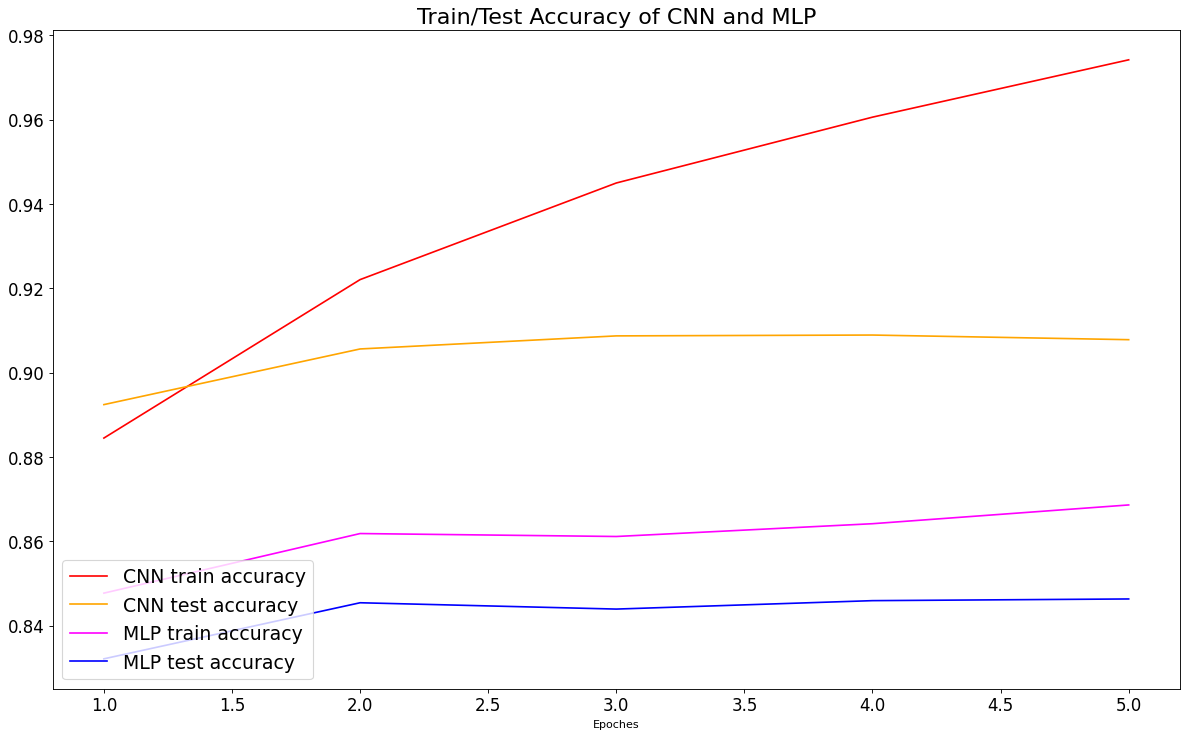

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
c = ['red','orange','magenta','blue','navy','green','turquoise','darkviolet',
     'gray','violet','lime','gold','indianred'] 
accuracy_list = [CNN_history['accuracy'],CNN_history['val_accuracy'],MLP_history['train_acc'],MLP_history['test_acc']]
label_list = ["CNN train accuracy","CNN test accuracy","MLP train accuracy","MLP test accuracy"]
x_axis = [1,2,3,4,5]
for i in range(4):
    plt.subplot(2,2,1)
    
    plt.title("Train/Test Accuracy of CNN and MLP", fontsize=20)
    plt.plot(x_axis,accuracy_list[i],label=label_list[i],color=c[i])
    
    plt.xlabel("Epoches")
    plt.legend(loc=3, fontsize=17)

plt.show()